In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# Gradients Parcelwise PLS

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# Define gradients and files
grad_files = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names = ['G1', 'G2', 'G3']

# Behavioral variables
clinical_vars = ['SAPSDisorganization', 'Amotivation', 'DimEx',
                 'SAPSPositiveSymptoms', 'hamilton_21', 'Long_free_recall',
                 'Short_free_recall', 'Free_recall_correct', 'Digit_span_backward',
                 'Digit_span_forward', 'Digit_span_sequencing', 'Letter_number_sequencing',
                 'Matrix_Reasoning', 'Vocabulary', 'YMRS']

# Store results
results = {}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"Processing {grad_name}...")
    
    # Load gradient
    grad_df = pd.read_csv(grad_file)
    patient_df = grad_df[grad_df['diagnosis'].isin([2, 3])].copy()
    
    # Extract parcel values
    parcel_cols = [f'node_{i+1}' for i in range(400)]
    X = patient_df[parcel_cols].values
    Y = patient_df[clinical_vars].values
    
    # Remove patients with NaNs
    valid = ~np.isnan(Y).any(axis=1)
    X_valid = X[valid]
    Y_valid = Y[valid]
    
    # Standardize
    X_std = StandardScaler().fit_transform(X_valid)
    Y_std = StandardScaler().fit_transform(Y_valid)
    
    # Fit PLS
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)
    
    # Individual composite scores
    X_scores = pls.x_scores_[:,0]
    Y_scores = pls.y_scores_[:,0]
    
    # Behavioral correlations
    behav_corrs = [pearsonr(Y_std[:,i], Y_scores)[0] for i in range(Y_std.shape[1])]
    
    # Save results
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': pls.x_loadings_[:,0],
        'Y_saliences': pls.y_loadings_[:,0],
        'behav_corrs': dict(zip(clinical_vars, behav_corrs)),
        'valid_idx': valid,
        'patient_df': patient_df[valid]
    }

for grad_name in results.keys():
    print(f"\n{grad_name} behavioral correlations:")
    for var, corr in results[grad_name]['behav_corrs'].items():
        print(f"{var}: {corr:.3f}")



Processing G1...
Processing G2...
Processing G3...

G1 behavioral correlations:
SAPSDisorganization: -0.427
Amotivation: -0.505
DimEx: -0.423
SAPSPositiveSymptoms: -0.700
hamilton_21: -0.209
Long_free_recall: 0.557
Short_free_recall: 0.615
Free_recall_correct: 0.619
Digit_span_backward: 0.578
Digit_span_forward: 0.543
Digit_span_sequencing: 0.642
Letter_number_sequencing: 0.575
Matrix_Reasoning: 0.610
Vocabulary: 0.574
YMRS: -0.194

G2 behavioral correlations:
SAPSDisorganization: -0.384
Amotivation: -0.484
DimEx: -0.403
SAPSPositiveSymptoms: -0.682
hamilton_21: -0.201
Long_free_recall: 0.595
Short_free_recall: 0.655
Free_recall_correct: 0.581
Digit_span_backward: 0.596
Digit_span_forward: 0.559
Digit_span_sequencing: 0.675
Letter_number_sequencing: 0.603
Matrix_Reasoning: 0.618
Vocabulary: 0.596
YMRS: -0.173

G3 behavioral correlations:
SAPSDisorganization: 0.005
Amotivation: 0.094
DimEx: 0.195
SAPSPositiveSymptoms: 0.373
hamilton_21: -0.144
Long_free_recall: -0.678
Short_free_recall:

# Subcortical embedding PLS

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# ------------------------
# Define subcortical gradients
# ------------------------
subcortical_files = [
    './g1_subcortical_cog.csv',
    './g2_subcortical_cog.csv',
    './g3_subcortical_cog.csv'
]
subcortical_names = ['SubG1', 'SubG2', 'SubG3']

# Subcortical parcels (same across all gradients)
sub_cols = [
    'sub_Accumbens_L', 'sub_Accumbens_R',
    'sub_Amygdala_L', 'sub_Amygdala_R',
    'sub_Caudate_L', 'sub_Caudate_R',
    'sub_Hippocampus_L', 'sub_Hippocampus_R',
    'sub_Pallidum_L', 'sub_Pallidum_R',
    'sub_Putamen_L', 'sub_Putamen_R',
    'sub_Thalamus_L', 'sub_Thalamus_R'
]

# Behavioral/clinical measures
clinical_vars = [
    'SAPSDisorganization', 'Amotivation', 'DimEx',
    'SAPSPositiveSymptoms', 'hamilton_21', 'Long_free_recall',
    'Short_free_recall', 'Free_recall_correct', 'Digit_span_backward',
    'Digit_span_forward', 'Digit_span_sequencing', 'Letter_number_sequencing',
    'Matrix_Reasoning', 'Vocabulary', 'YMRS'
]

# ------------------------
# Run loop over gradients
# ------------------------
results_sub = {}

for fname, gname in zip(subcortical_files, subcortical_names):
    print(f"\nProcessing {gname}...")

    # Load gradient
    df = pd.read_csv(fname)
    patients = df[df['diagnosis'].isin([2,3])].copy()

    # Extract X (subcortical embedding) and Y (behavior)
    X = patients[sub_cols].values
    Y = patients[clinical_vars].values

    # Remove patients with NaNs
    valid = ~np.isnan(Y).any(axis=1)
    X_valid = X[valid]
    Y_valid = Y[valid]

    # Standardize
    X_std = StandardScaler().fit_transform(X_valid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # Fit PLS (LC1 only)
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)

    # Extract loadings and scores
    X_scores = pls.x_scores_[:,0]
    Y_scores = pls.y_scores_[:,0]
    X_saliences = pls.x_loadings_[:,0]
    Y_saliences = pls.y_loadings_[:,0]

    # Behavioral correlations
    behav_corrs = [pearsonr(Y_std[:,i], Y_scores)[0] for i in range(Y_std.shape[1])]

    # Save results
    results_sub[gname] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': dict(zip(clinical_vars, behav_corrs)),
        'valid_idx': valid,
        'patient_df': patients[valid]
    }

    # Print summary correlations
    print(f"{gname} behavioral correlations:")
    for var, corr in results_sub[gname]['behav_corrs'].items():
        print(f"  {var}: {corr:.3f}")


## Cortical projection of loadings

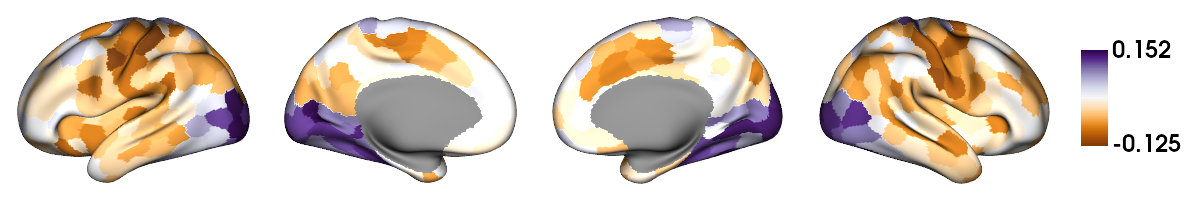

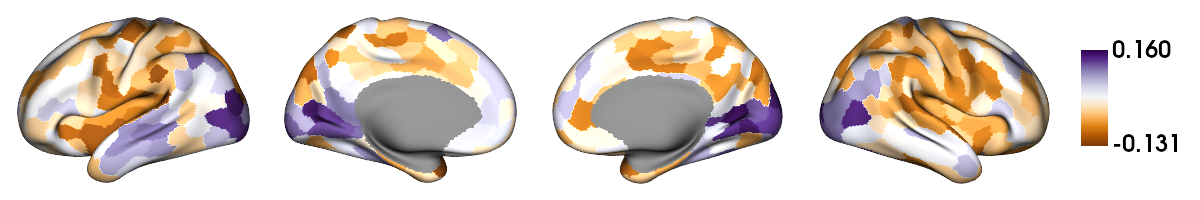

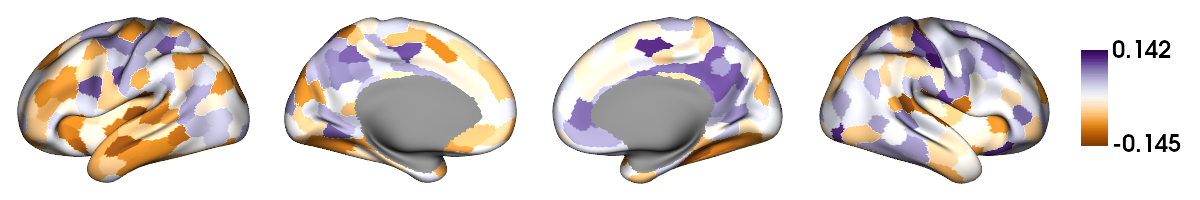

In [21]:
from IPython.display import Image, display
import numpy as np

for grad_name in results.keys():
    X_saliences = results[grad_name]['X_saliences']
    
    brain_map = np.full_like(atlas, np.nan, dtype=float)
    for j in range(len(X_saliences)):
        brain_map[atlas == j+1] = X_saliences[j]
    brain_map[atlas == 0] = np.nan

    filename = f'./new_figures/{grad_name}_LC1_map_cortex.png'
    fp.plot_surface(
        data=[brain_map],
        size=(1200, 200),
        cmap='PuOr',
        display=False,  # save instead of interactive window
        filename=filename
    )
    display(Image(filename))


## Behavioral loadings 

Bootstrapping behavioral loadings for G1...


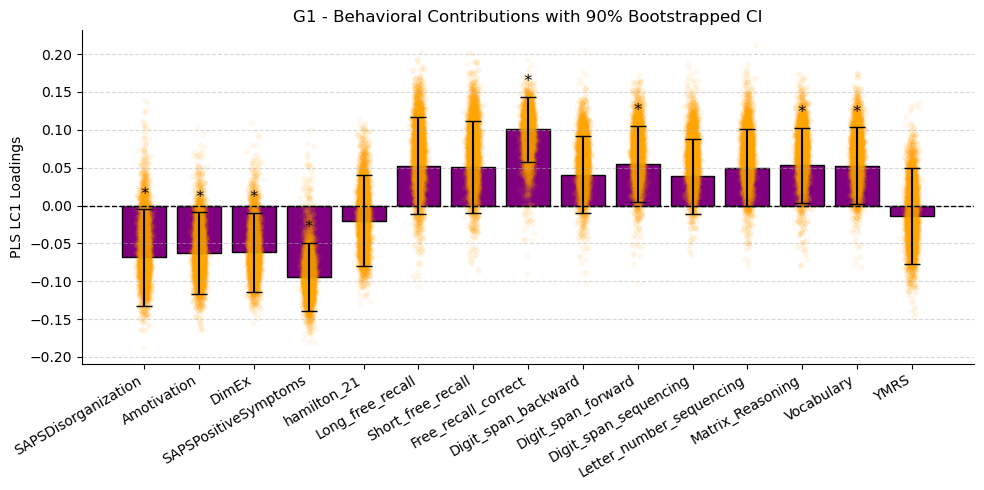

Bootstrapping behavioral loadings for G2...


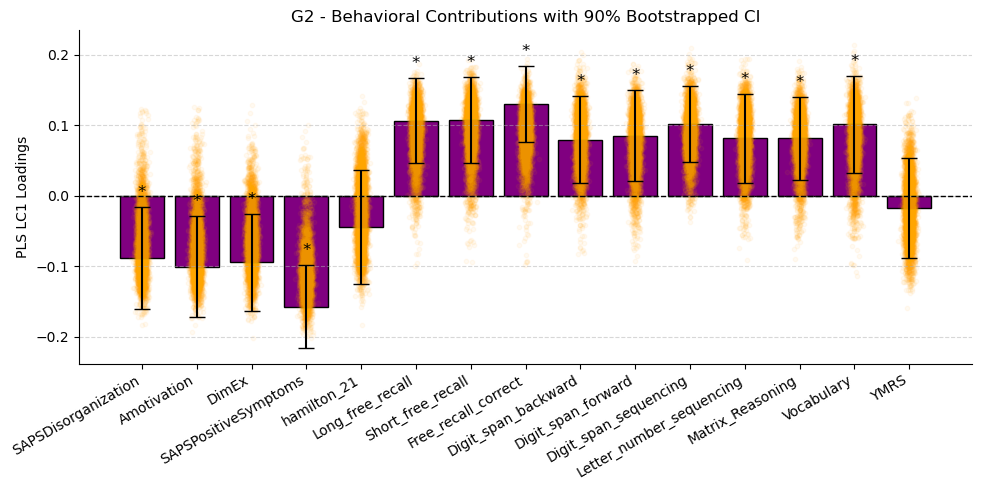

Bootstrapping behavioral loadings for G3...


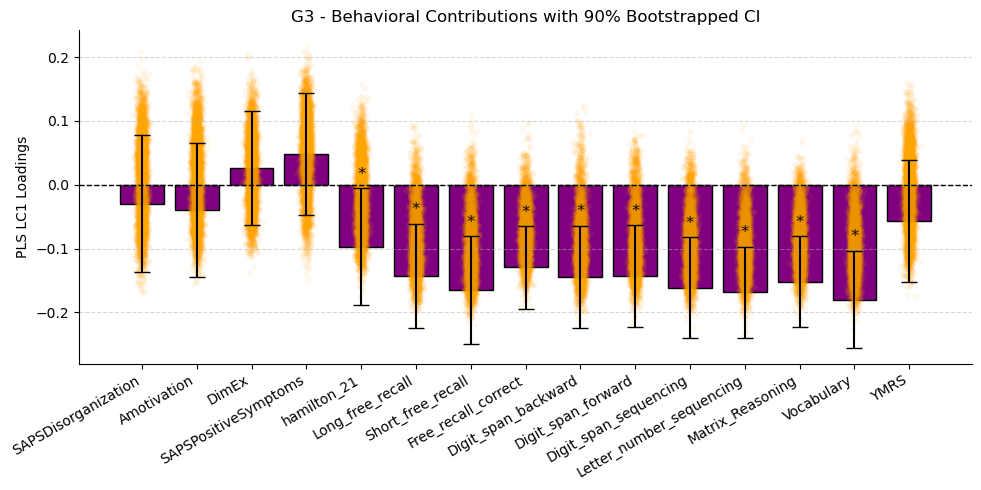

Bootstrapping behavioral loadings for SubG1...


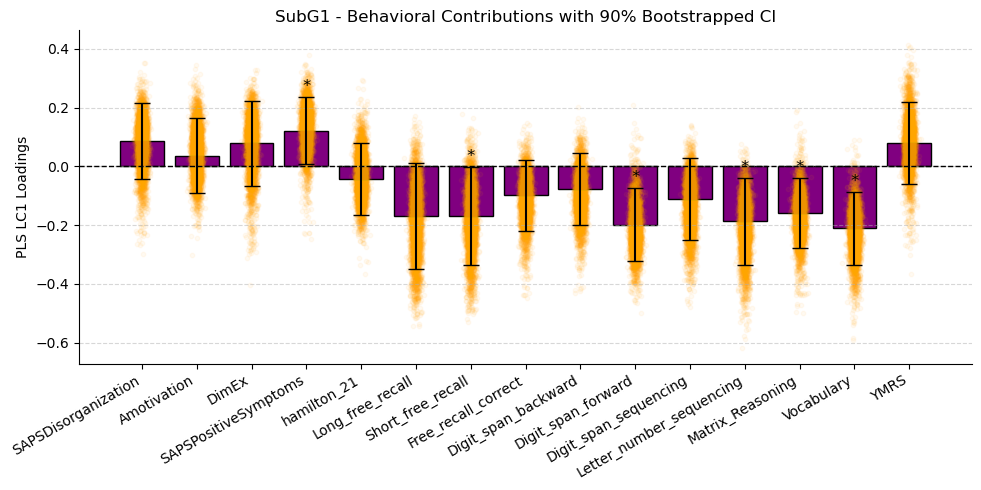

Bootstrapping behavioral loadings for SubG2...


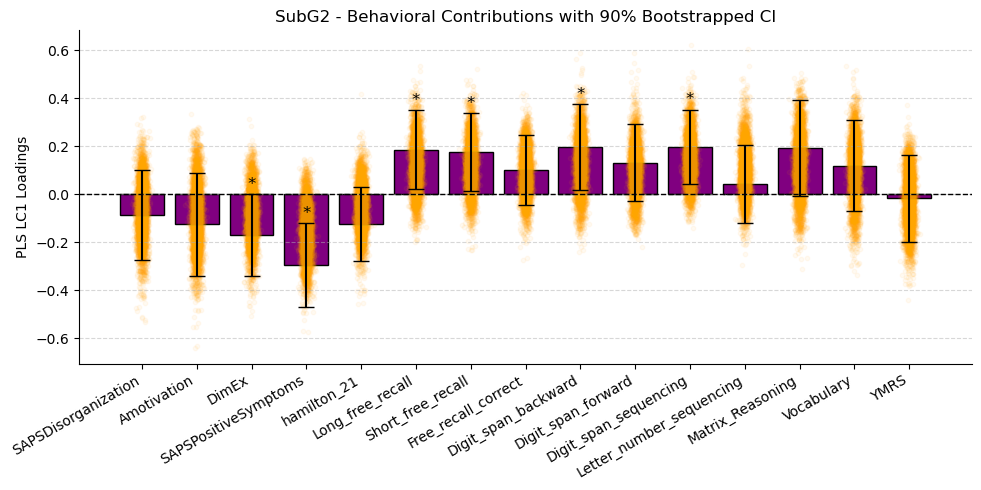

Bootstrapping behavioral loadings for SubG3...


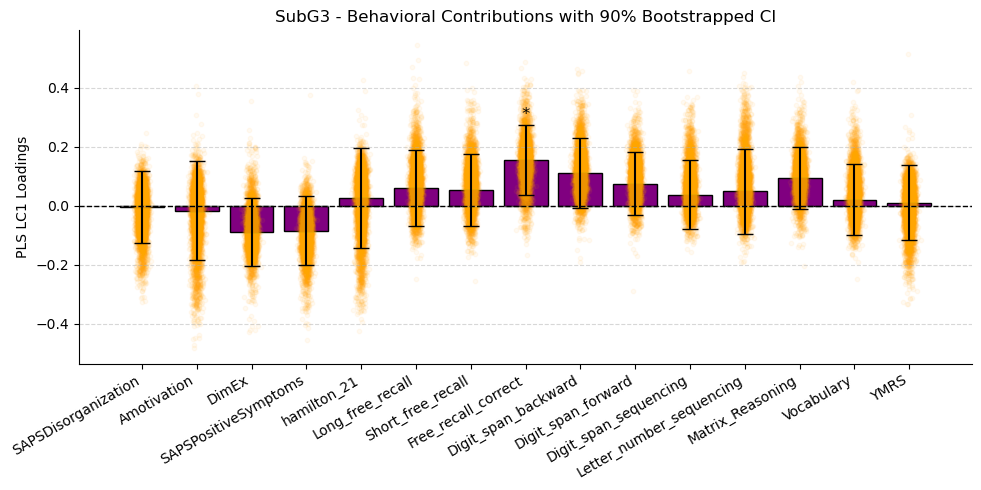

In [31]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import norm

n_boot = 5000

# Combine cortical and subcortical results if you want
all_results = {**results, **results_sub}

for grad_name, res in all_results.items():
    print(f"Bootstrapping behavioral loadings for {grad_name}...")

    # Recompute X, Y from patient_df (so it works for cortex or subcortex)
    feature_cols = [c for c in res['patient_df'].columns if c.startswith('node_') or c.startswith('sub_')]
    X_std = StandardScaler().fit_transform(res['patient_df'][feature_cols].values)
    Y_std = StandardScaler().fit_transform(res['patient_df'][clinical_vars].values)
    Y_saliences = res['Y_saliences']

    n_behav = Y_std.shape[1]
    boot_y_saliences = np.zeros((n_boot, n_behav))

    # -------- Bootstrap --------
    for b in range(n_boot):
        idx = np.random.choice(len(X_std), size=len(X_std), replace=True)
        Xb = X_std[idx]
        Yb = Y_std[idx]

        plsb = PLSRegression(n_components=1)
        plsb.fit(Xb, Yb)
        yb = plsb.y_loadings_[:, 0]

        # Align sign
        if np.dot(yb, Y_saliences) < 0:
            yb *= -1
        boot_y_saliences[b, :] = yb

    # -------- Statistics --------
    y_mean = Y_saliences
    y_sd = boot_y_saliences.std(axis=0)
    lower_ci = y_mean - 1.645 * y_sd
    upper_ci = y_mean + 1.645 * y_sd
    p_values = 2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

    # -------- Plot --------
    fig, ax = plt.subplots(figsize=(10,5))
    bars = ax.bar(range(n_behav), y_mean,
                  yerr=[y_mean - lower_ci, upper_ci - y_mean],
                  capsize=6, color='purple', alpha=1, edgecolor='black')

    # Overlay bootstrap points
    for i in range(n_behav):
        y = boot_y_saliences[:, i]
        x = np.random.normal(i, 0.05, size=len(y))
        ax.scatter(x, y, color='orange', alpha=0.05, s=10)

    # Zero line
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # Significance stars
    for i in range(n_behav):
        if lower_ci[i] > 0 or upper_ci[i] < 0:
            ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

    # Labels
    ax.set_xticks(range(n_behav))
    ax.set_xticklabels(clinical_vars, rotation=30, ha='right')
    ax.set_ylabel('PLS LC1 Loadings')
    ax.set_title(f'{grad_name} - Behavioral Contributions with 90% Bootstrapped CI')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


## Behavioral loadings with Kebets' corrections


Processing G1 behavioral loadings...
                    behavior  mean_loading      sd  ci90_lower  ci90_upper  \
0        SAPSDisorganization       -0.0685  0.0380     -0.1123      0.0105   
1                Amotivation       -0.0630  0.0330     -0.1092     -0.0024   
2                      DimEx       -0.0617  0.0310     -0.1048     -0.0053   
3       SAPSPositiveSymptoms       -0.0944  0.0271     -0.1300     -0.0454   
4                hamilton_21       -0.0200  0.0368     -0.0744      0.0471   
5           Long_free_recall        0.0526  0.0381      0.0022      0.1282   
6          Short_free_recall        0.0503  0.0363      0.0080      0.1271   
7        Free_recall_correct        0.1006  0.0259      0.0505      0.1313   
8        Digit_span_backward        0.0404  0.0308      0.0037      0.1040   
9         Digit_span_forward        0.0555  0.0300      0.0172      0.1146   
10     Digit_span_sequencing        0.0385  0.0298      0.0123      0.1105   
11  Letter_number_sequenci

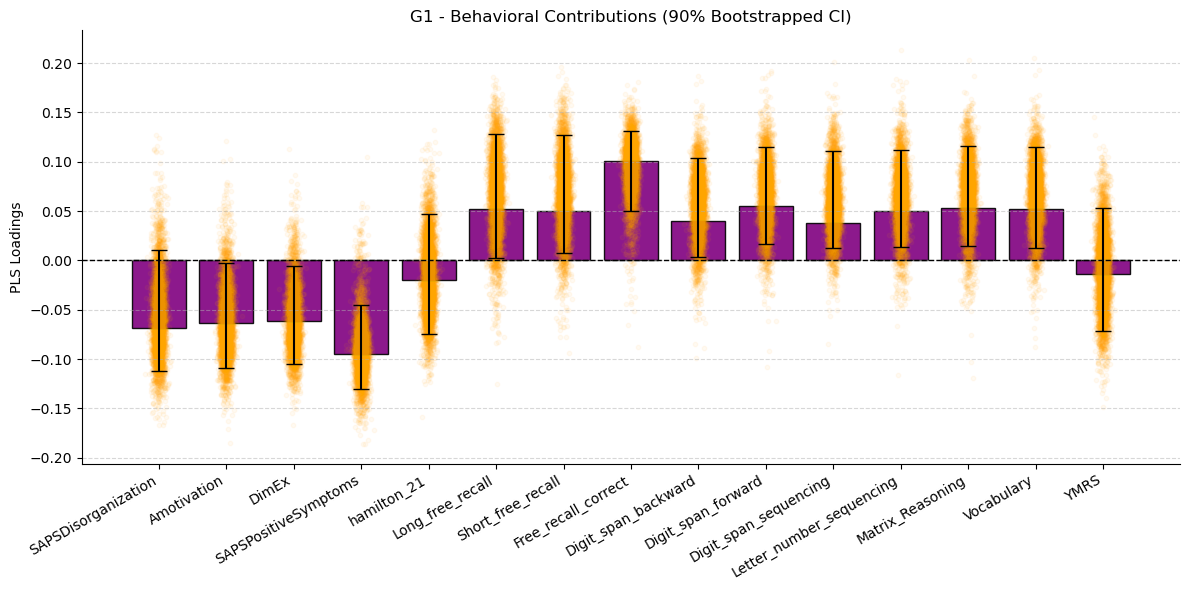


Processing G2 behavioral loadings...
                    behavior  mean_loading      sd  ci90_lower  ci90_upper  \
0        SAPSDisorganization       -0.0884  0.0445     -0.1258      0.0166   
1                Amotivation       -0.1003  0.0440     -0.1324      0.0089   
2                      DimEx       -0.0945  0.0412     -0.1266      0.0083   
3       SAPSPositiveSymptoms       -0.1575  0.0355     -0.1556     -0.0445   
4                hamilton_21       -0.0444  0.0493     -0.0992      0.0600   
5           Long_free_recall        0.1062  0.0365      0.0200      0.1371   
6          Short_free_recall        0.1071  0.0366      0.0241      0.1452   
7        Free_recall_correct        0.1300  0.0320      0.0373      0.1384   
8        Digit_span_backward        0.0797  0.0376      0.0119      0.1339   
9         Digit_span_forward        0.0852  0.0381      0.0069      0.1313   
10     Digit_span_sequencing        0.1013  0.0328      0.0332      0.1411   
11  Letter_number_sequenci

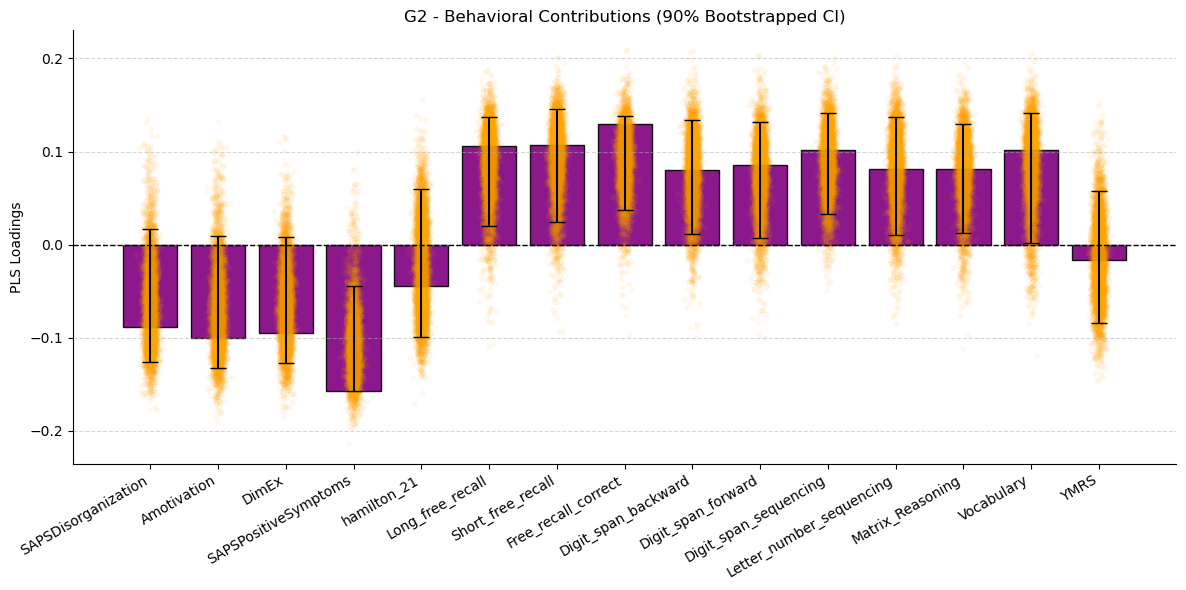


Processing G3 behavioral loadings...
                    behavior  mean_loading      sd  ci90_lower  ci90_upper  \
0        SAPSDisorganization       -0.0299  0.0664     -0.0981      0.1138   
1                Amotivation       -0.0391  0.0648     -0.0921      0.1169   
2                      DimEx        0.0260  0.0550     -0.0683      0.1090   
3       SAPSPositiveSymptoms        0.0478  0.0591     -0.0566      0.1385   
4                hamilton_21       -0.0971  0.0556     -0.1086      0.0710   
5           Long_free_recall       -0.1427  0.0499     -0.1563      0.0068   
6          Short_free_recall       -0.1654  0.0519     -0.1677      0.0043   
7        Free_recall_correct       -0.1295  0.0403     -0.1333     -0.0025   
8        Digit_span_backward       -0.1444  0.0500     -0.1609      0.0052   
9         Digit_span_forward       -0.1430  0.0489     -0.1553      0.0073   
10     Digit_span_sequencing       -0.1612  0.0480     -0.1629     -0.0005   
11  Letter_number_sequenci

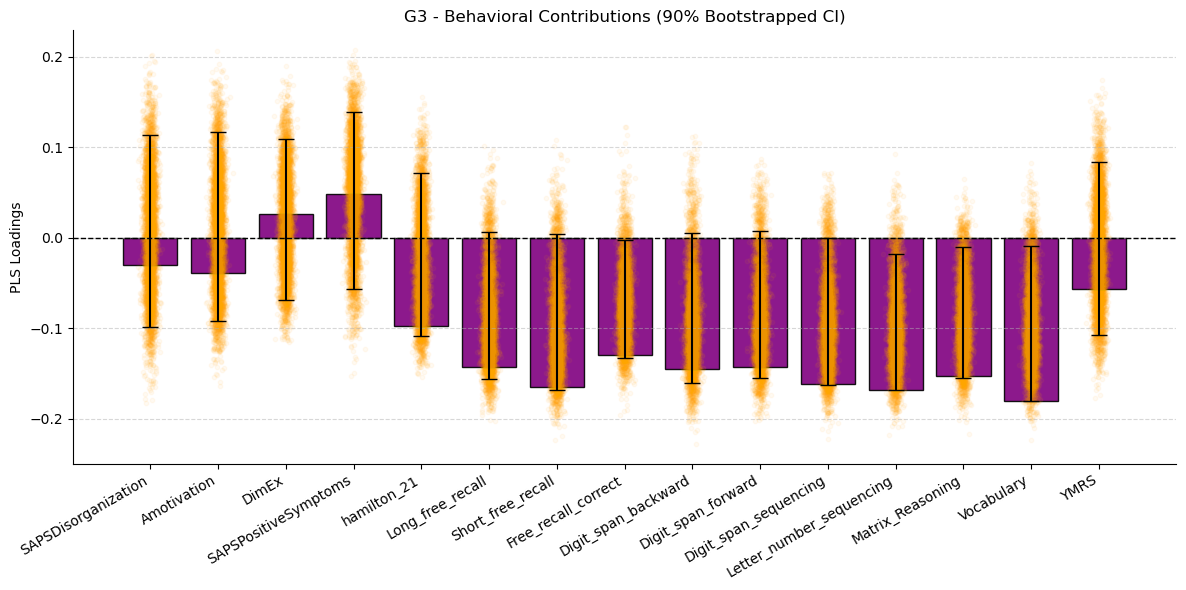


Processing SubG1 behavioral loadings...
                    behavior  mean_loading      sd  ci90_lower  ci90_upper  \
0        SAPSDisorganization        0.0866  0.0808     -0.0611      0.1989   
1                Amotivation        0.0369  0.0794     -0.0832      0.1751   
2                      DimEx        0.0783  0.0879     -0.0879      0.2037   
3       SAPSPositiveSymptoms        0.1215  0.0709      0.0057      0.2337   
4                hamilton_21       -0.0422  0.0749     -0.1535      0.0905   
5           Long_free_recall       -0.1696  0.1095     -0.3705     -0.0091   
6          Short_free_recall       -0.1687  0.1004     -0.3536     -0.0209   
7        Free_recall_correct       -0.0988  0.0758     -0.2428      0.0033   
8        Digit_span_backward       -0.0779  0.0753     -0.2132      0.0284   
9         Digit_span_forward       -0.1983  0.0768     -0.3243     -0.0763   
10     Digit_span_sequencing       -0.1100  0.0851     -0.2851     -0.0044   
11  Letter_number_seque

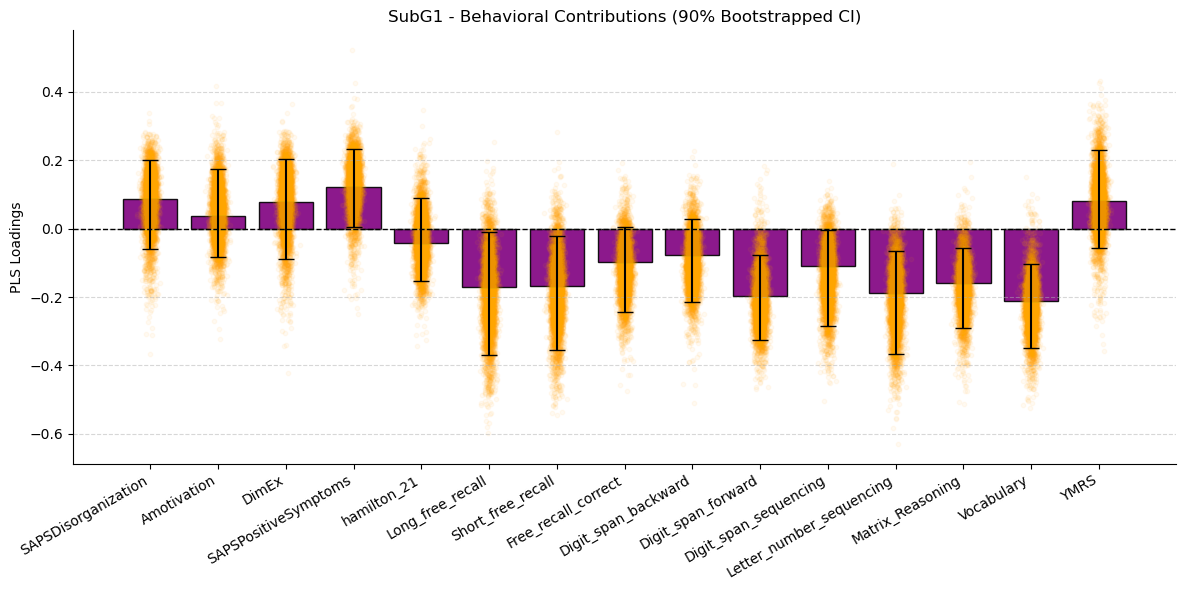


Processing SubG2 behavioral loadings...
                    behavior  mean_loading      sd  ci90_lower  ci90_upper  \
0        SAPSDisorganization       -0.0858  0.1137     -0.2502      0.1179   
1                Amotivation       -0.1257  0.1313     -0.2977      0.1273   
2                      DimEx       -0.1707  0.1032     -0.2605      0.0808   
3       SAPSPositiveSymptoms       -0.2954  0.1058     -0.3316      0.0216   
4                hamilton_21       -0.1251  0.0939     -0.2094      0.0916   
5           Long_free_recall        0.1859  0.1021     -0.0501      0.2923   
6          Short_free_recall        0.1747  0.0993     -0.0407      0.2887   
7        Free_recall_correct        0.1010  0.0891     -0.0543      0.2345   
8        Digit_span_backward        0.1974  0.1083     -0.0503      0.3127   
9         Digit_span_forward        0.1320  0.0965     -0.0598      0.2565   
10     Digit_span_sequencing        0.1980  0.0939     -0.0039      0.3022   
11  Letter_number_seque

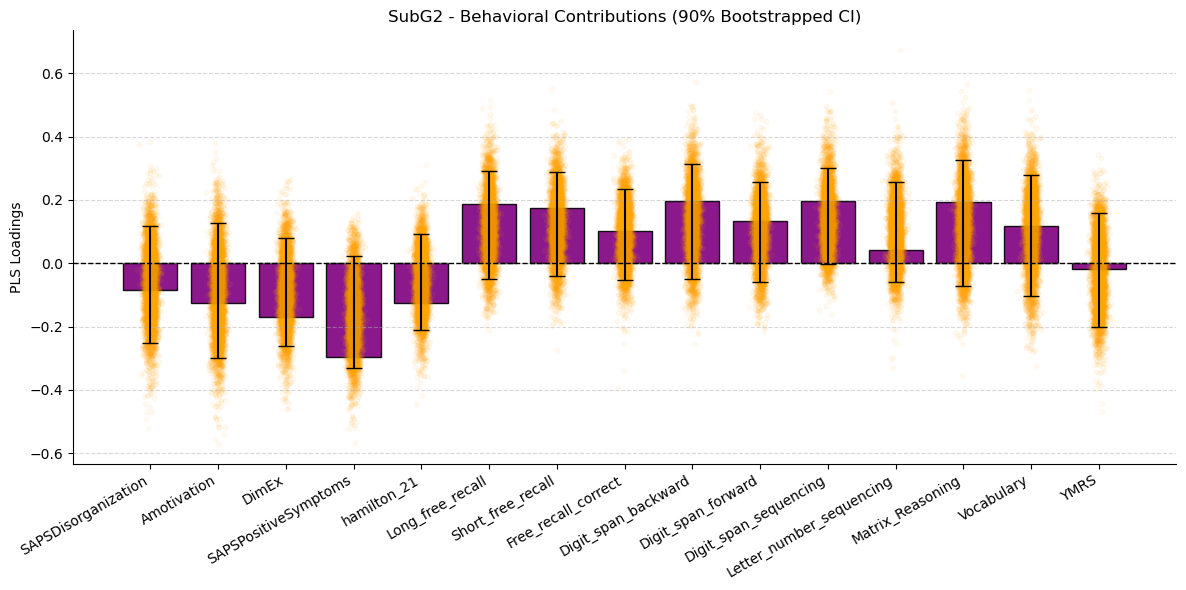


Processing SubG3 behavioral loadings...
                    behavior  mean_loading      sd  ci90_lower  ci90_upper  \
0        SAPSDisorganization       -0.0046  0.0742     -0.1586      0.0856   
1                Amotivation       -0.0178  0.0998     -0.2367      0.1008   
2                      DimEx       -0.0901  0.0701     -0.1893      0.0355   
3       SAPSPositiveSymptoms       -0.0851  0.0694     -0.2142      0.0121   
4                hamilton_21        0.0247  0.1039     -0.2075      0.1442   
5           Long_free_recall        0.0584  0.0773     -0.0442      0.2062   
6          Short_free_recall        0.0525  0.0729     -0.0447      0.1928   
7        Free_recall_correct        0.1555  0.0708      0.0307      0.2662   
8        Digit_span_backward        0.1095  0.0716      0.0110      0.2446   
9         Digit_span_forward        0.0747  0.0651     -0.0140      0.2008   
10     Digit_span_sequencing        0.0366  0.0710     -0.0416      0.1989   
11  Letter_number_seque

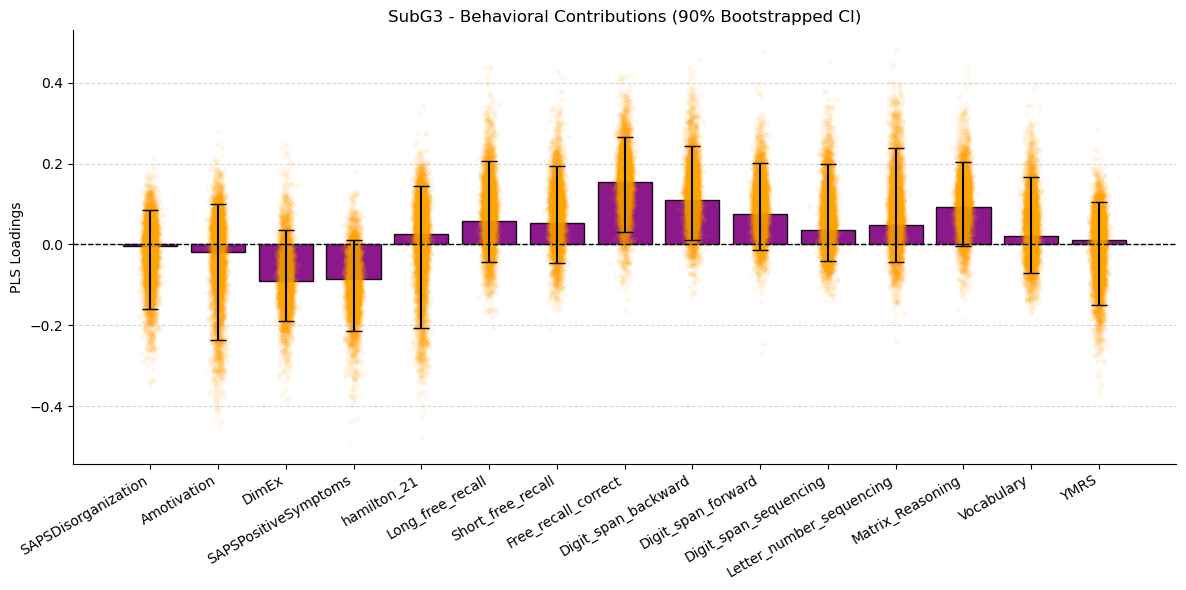

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ------------------------
# PARAMETERS
# ------------------------
n_perm = 1000      # number of permutations for LC significance
n_boot = 5000      # bootstrap samples
alpha = 0.05       # FDR alpha
rng = np.random.default_rng(4)

# Merge cortical and subcortical results
all_results = {**results, **results_sub}

for grad_name, res in all_results.items():
    print(f"\nProcessing {grad_name} behavioral loadings...")

    # ---- Pick correct feature set depending on cortex vs subcortex ----
    df = res['patient_df']
    if any(col.startswith("node_") for col in df.columns):
        X_std = StandardScaler().fit_transform(df[[f'node_{i+1}' for i in range(400)]].values)
    else:  # subcortex
        sub_cols = [c for c in df.columns if c.startswith("sub_")]
        X_std = StandardScaler().fit_transform(df[sub_cols].values)

    Y_std = StandardScaler().fit_transform(df[clinical_vars].values)
    Y_saliences = res['Y_saliences']

    n, q = X_std.shape[0], Y_std.shape[1]

    # ------------------------
    # 1) Permutation test (LC significance)
    # ------------------------
    perm_s = np.zeros((n_perm, 1))  # only 1 LC
    for i in range(n_perm):
        perm_idx = rng.permutation(n)
        Yp = Y_std[perm_idx]
        Cp = (X_std.T @ Yp) / n
        s_perm = np.linalg.svd(Cp, full_matrices=False)[1]
        perm_s[i, 0] = s_perm[0]

    # ------------------------
    # 2) Bootstrap behavioral loadings
    # ------------------------
    boot_y = np.zeros((n_boot, q))
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        Xb = X_std[idx]
        Yb = Y_std[idx]
        plsb = PLSRegression(n_components=1)
        plsb.fit(Xb, Yb)
        yb = plsb.y_loadings_[:, 0].copy()
        # Align sign
        if np.dot(yb, Y_saliences) < 0:
            yb *= -1
        boot_y[b, :] = yb

    y_mean = Y_saliences
    y_sd = boot_y.std(axis=0)
    lower_ci = np.percentile(boot_y, 5, axis=0)
    upper_ci = np.percentile(boot_y, 95, axis=0)

    prop_ge0 = (boot_y >= 0).sum(axis=0) / n_boot
    p_two_sided_emp = 2.0 * np.minimum(prop_ge0, 1.0 - prop_ge0)
    p_two_sided_emp = np.minimum(p_two_sided_emp, 1.0)

    rej_behav, pvals_behav_fdr, _, _ = multipletests(p_two_sided_emp, alpha=alpha, method='fdr_bh')

    # ------------------------
    # 3) Summary table
    # ------------------------
    df_beh = pd.DataFrame({
        'behavior': clinical_vars,
        'mean_loading': y_mean,
        'sd': y_sd,
        'ci90_lower': lower_ci,
        'ci90_upper': upper_ci,
        'p_two_sided_emp': p_two_sided_emp,
        'p_fdr_behav': pvals_behav_fdr,
        'signif_fdr': rej_behav
    })
    print(df_beh.round(4))

    # ------------------------
    # 4) Visualization
    # ------------------------
    fig, ax = plt.subplots(figsize=(12,6))
    lower_err = np.maximum(y_mean - lower_ci, 0)
    upper_err = np.maximum(upper_ci - y_mean, 0)
    yerr = [lower_err, upper_err]

    bars = ax.bar(range(q), y_mean, yerr=yerr, capsize=6, color='purple', alpha=0.9, edgecolor='black')

    # Overlay bootstrap points
    for i in range(q):
        y = boot_y[:, i]
        x = np.random.normal(i, 0.05, size=len(y))
        ax.scatter(x, y, color='orange', alpha=0.05, s=10)

    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # Stars for FDR-significant behaviors
    for i in range(q):
        if rej_behav[i]:
            ax.text(i, upper_ci[i] + 0.02, "*", ha='center', va='bottom', fontsize=14, color='red')

    ax.set_xticks(range(q))
    ax.set_xticklabels(clinical_vars, rotation=30, ha='right')
    ax.set_ylabel('PLS Loadings')
    ax.set_title(f'{grad_name} - Behavioral Contributions (90% Bootstrapped CI)')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()



Processing G1 behavioral correlations...
                    variable       r  boot_sd  ci90_lower  ci90_upper   p_emp  \
0        SAPSDisorganization -0.4275   0.1009     -0.5777     -0.2444  0.0004   
1                Amotivation -0.5052   0.0881     -0.6430     -0.3577  0.0000   
2                      DimEx -0.4227   0.1002     -0.5763     -0.2469  0.0004   
3       SAPSPositiveSymptoms -0.7004   0.0513     -0.7791     -0.6117  0.0000   
4                hamilton_21 -0.2088   0.0975     -0.3673     -0.0438  0.0408   
5           Long_free_recall  0.5573   0.0813      0.4149      0.6837  0.0000   
6          Short_free_recall  0.6152   0.0814      0.4712      0.7374  0.0000   
7        Free_recall_correct  0.6189   0.0563      0.5203      0.7050  0.0000   
8        Digit_span_backward  0.5776   0.0731      0.4528      0.6895  0.0000   
9         Digit_span_forward  0.5429   0.0903      0.3821      0.6816  0.0000   
10     Digit_span_sequencing  0.6418   0.0599      0.5375      0.73

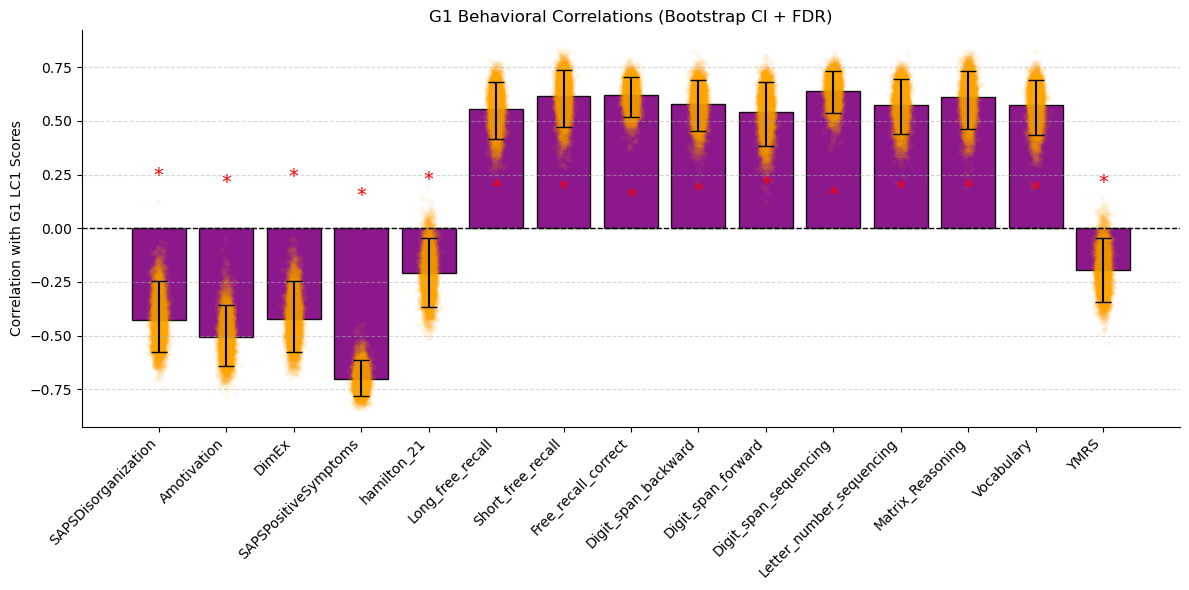


Processing G2 behavioral correlations...
                    variable       r  boot_sd  ci90_lower  ci90_upper   p_emp  \
0        SAPSDisorganization -0.3835   0.1013     -0.5358     -0.2026  0.0008   
1                Amotivation -0.4840   0.0894     -0.6216     -0.3263  0.0000   
2                      DimEx -0.4028   0.1047     -0.5647     -0.2162  0.0008   
3       SAPSPositiveSymptoms -0.6817   0.0537     -0.7639     -0.5881  0.0000   
4                hamilton_21 -0.2014   0.0996     -0.3646     -0.0390  0.0468   
5           Long_free_recall  0.5946   0.0765      0.4634      0.7110  0.0000   
6          Short_free_recall  0.6545   0.0748      0.5232      0.7653  0.0000   
7        Free_recall_correct  0.5808   0.0598      0.4786      0.6754  0.0000   
8        Digit_span_backward  0.5957   0.0727      0.4715      0.7066  0.0000   
9         Digit_span_forward  0.5587   0.0898      0.3980      0.6938  0.0000   
10     Digit_span_sequencing  0.6754   0.0574      0.5703      0.76

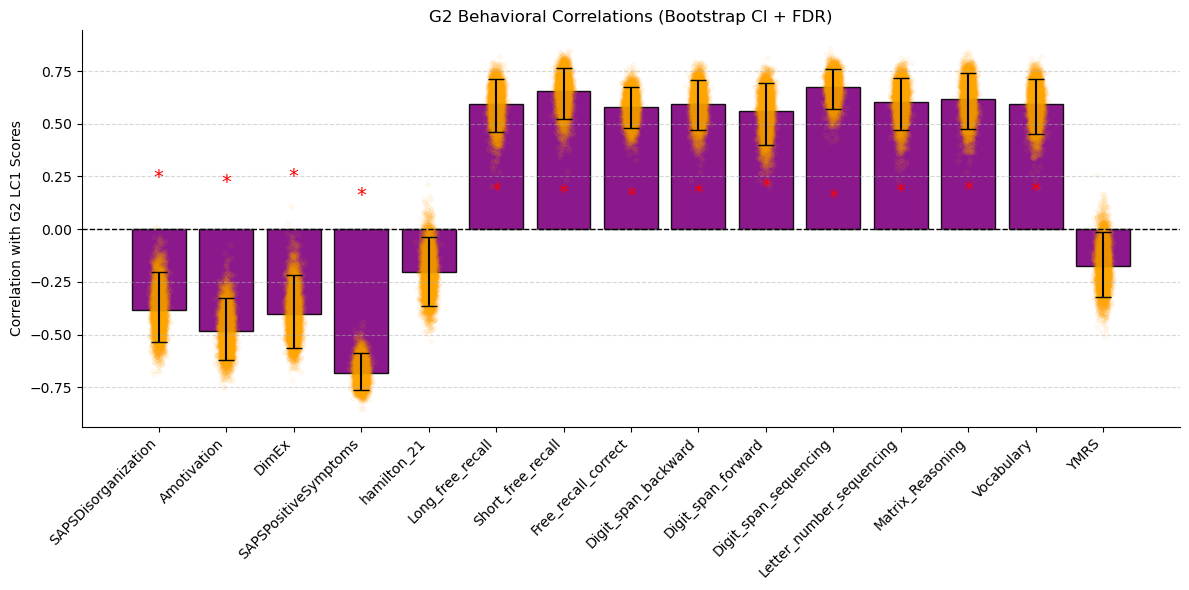


Processing G3 behavioral correlations...
                    variable       r  boot_sd  ci90_lower  ci90_upper   p_emp  \
0        SAPSDisorganization  0.0053   0.1072     -0.1735      0.1753  0.9768   
1                Amotivation  0.0935   0.1035     -0.0830      0.2620  0.3772   
2                      DimEx  0.1949   0.1100      0.0086      0.3635  0.0888   
3       SAPSPositiveSymptoms  0.3728   0.0887      0.2258      0.5156  0.0000   
4                hamilton_21 -0.1441   0.0993     -0.3052      0.0203  0.1432   
5           Long_free_recall -0.6784   0.0683     -0.7791     -0.5537  0.0000   
6          Short_free_recall -0.7232   0.0609     -0.8110     -0.6144  0.0000   
7        Free_recall_correct -0.5184   0.0831     -0.6571     -0.3809  0.0000   
8        Digit_span_backward -0.6492   0.0673     -0.7498     -0.5292  0.0000   
9         Digit_span_forward -0.6681   0.0682     -0.7686     -0.5470  0.0000   
10     Digit_span_sequencing -0.6833   0.0571     -0.7686     -0.58

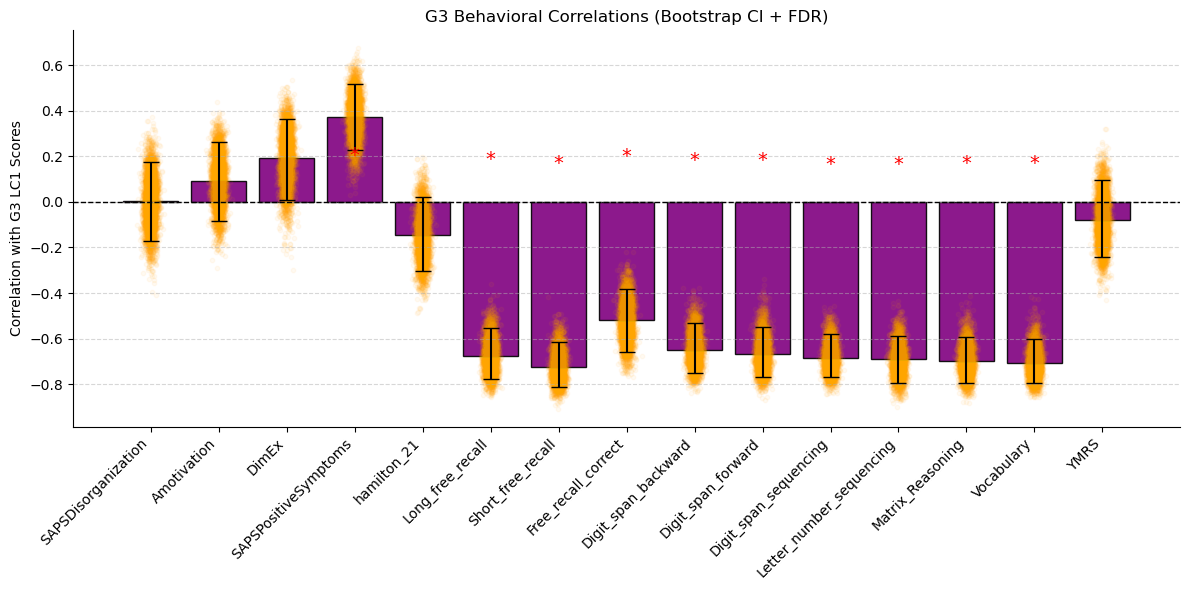


Processing SubG1 behavioral correlations...
                    variable       r  boot_sd  ci90_lower  ci90_upper   p_emp  \
0        SAPSDisorganization  0.2683   0.0997      0.1009      0.4273  0.0116   
1                Amotivation  0.2833   0.1007      0.1165      0.4478  0.0092   
2                      DimEx  0.2535   0.1095      0.0665      0.4241  0.0320   
3       SAPSPositiveSymptoms  0.5254   0.0700      0.4075      0.6377  0.0000   
4                hamilton_21  0.0362   0.1008     -0.1302      0.2014  0.7372   
5           Long_free_recall -0.6790   0.0682     -0.7781     -0.5542  0.0000   
6          Short_free_recall -0.7358   0.0616     -0.8220     -0.6207  0.0000   
7        Free_recall_correct -0.5243   0.0688     -0.6417     -0.4157  0.0000   
8        Digit_span_backward -0.5963   0.0736     -0.7086     -0.4663  0.0000   
9         Digit_span_forward -0.6497   0.0736     -0.7567     -0.5199  0.0000   
10     Digit_span_sequencing -0.6811   0.0595     -0.7698     -0

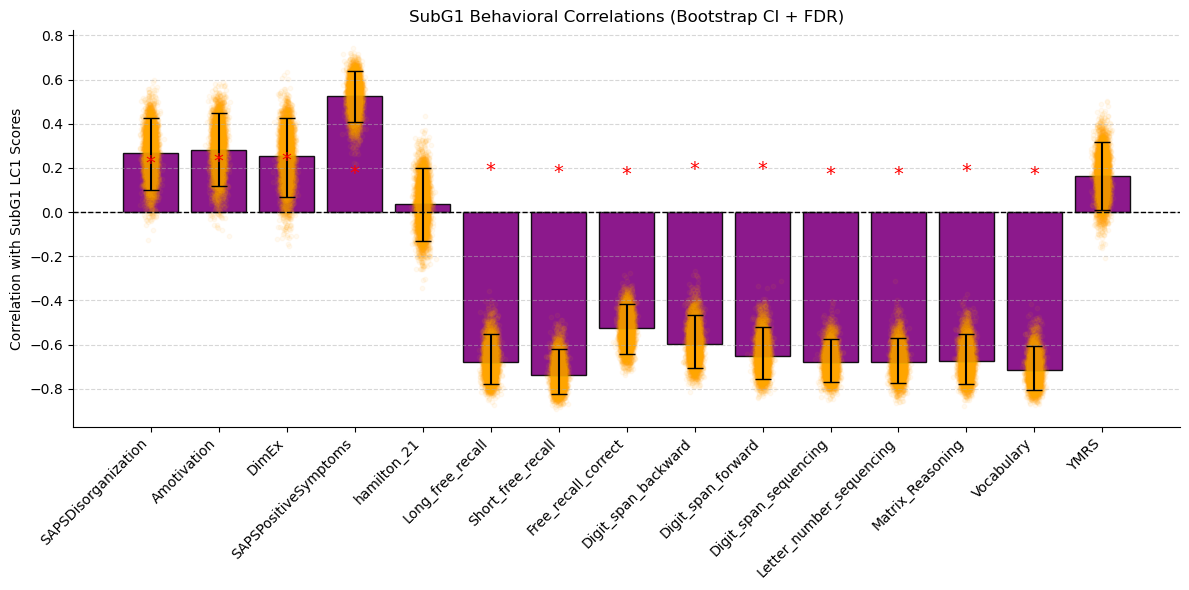


Processing SubG2 behavioral correlations...
                    variable       r  boot_sd  ci90_lower  ci90_upper   p_emp  \
0        SAPSDisorganization -0.3337   0.1042     -0.4976     -0.1523  0.0020   
1                Amotivation -0.4783   0.0876     -0.6144     -0.3277  0.0000   
2                      DimEx -0.4473   0.0996     -0.5985     -0.2722  0.0000   
3       SAPSPositiveSymptoms -0.6950   0.0528     -0.7778     -0.6033  0.0000   
4                hamilton_21 -0.2289   0.1031     -0.3931     -0.0510  0.0316   
5           Long_free_recall  0.5766   0.0760      0.4404      0.6931  0.0000   
6          Short_free_recall  0.6416   0.0780      0.4975      0.7547  0.0000   
7        Free_recall_correct  0.5190   0.0664      0.4065      0.6252  0.0000   
8        Digit_span_backward  0.6334   0.0667      0.5172      0.7373  0.0000   
9         Digit_span_forward  0.5641   0.0915      0.4039      0.7028  0.0000   
10     Digit_span_sequencing  0.6881   0.0554      0.5901      0

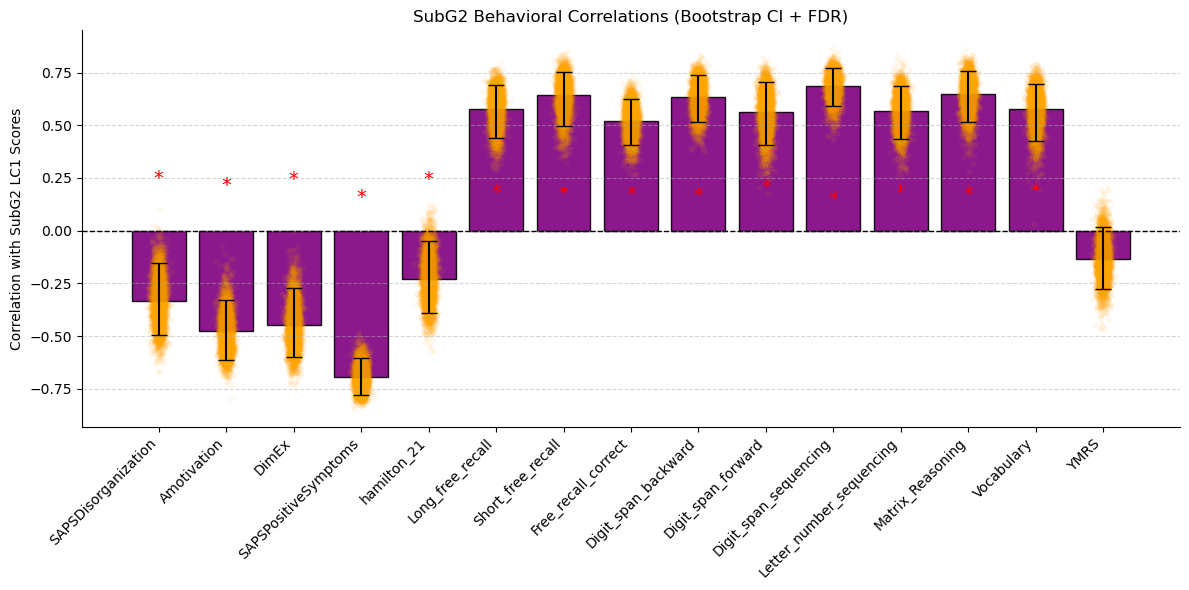


Processing SubG3 behavioral correlations...
                    variable       r  boot_sd  ci90_lower  ci90_upper   p_emp  \
0        SAPSDisorganization -0.1692   0.1126     -0.3467      0.0256  0.1568   
1                Amotivation -0.3186   0.1021     -0.4824     -0.1431  0.0016   
2                      DimEx -0.4376   0.1003     -0.5842     -0.2582  0.0004   
3       SAPSPositiveSymptoms -0.5890   0.0675     -0.6902     -0.4684  0.0000   
4                hamilton_21 -0.0346   0.0976     -0.1937      0.1277  0.7036   
5           Long_free_recall  0.5597   0.0799      0.4169      0.6796  0.0000   
6          Short_free_recall  0.5984   0.0829      0.4465      0.7191  0.0000   
7        Free_recall_correct  0.6732   0.0556      0.5789      0.7614  0.0000   
8        Digit_span_backward  0.6935   0.0544      0.5977      0.7757  0.0000   
9         Digit_span_forward  0.6306   0.0796      0.4903      0.7495  0.0000   
10     Digit_span_sequencing  0.6422   0.0569      0.5419      0

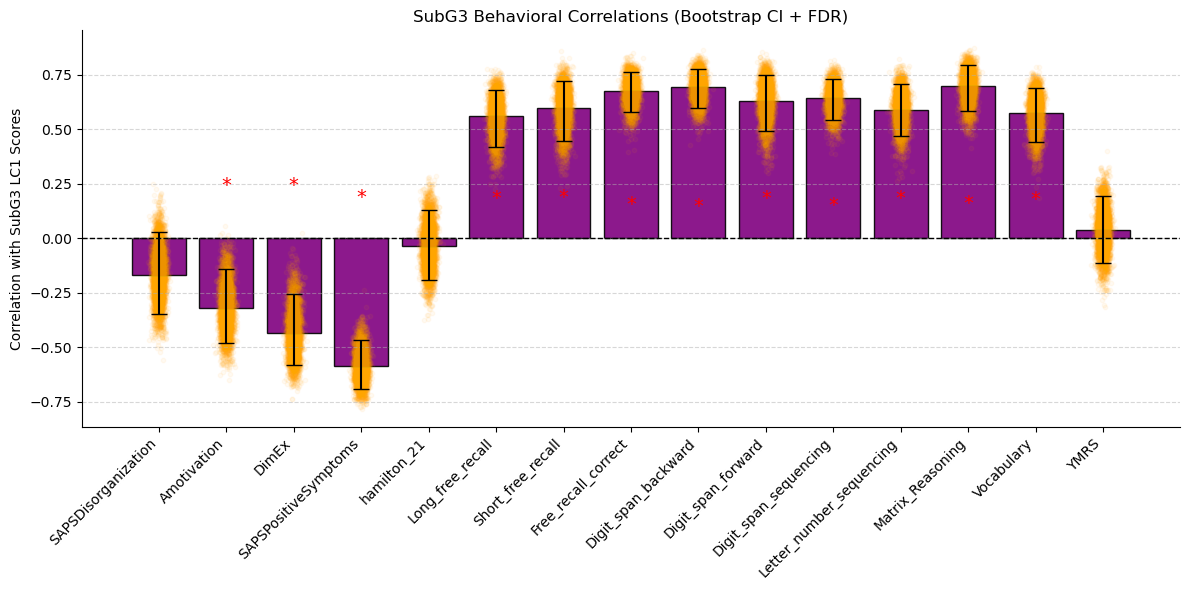

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.multitest import multipletests

# ------------------------
# PARAMETERS
# ------------------------
n_boot = 5000
alpha = 0.05
rng = np.random.default_rng(4)

# Merge cortex + subcortex results
all_results = {**results, **results_sub}

# Store results
corr_results = {}

for grad_name, res in all_results.items():
    print(f"\nProcessing {grad_name} behavioral correlations...")

    Y_std = res['patient_df'][clinical_vars].values
    Y_scores = res['Y_scores']

    # ------------------------
    # 1. Original correlations
    # ------------------------
    behav_corrs = np.array([
        np.corrcoef(Y_std[:, i], Y_scores)[0, 1]
        for i in range(Y_std.shape[1])
    ])

    # ------------------------
    # 2. Bootstrap correlations
    # ------------------------
    boot_corrs = np.zeros((n_boot, len(clinical_vars)))
    for b in range(n_boot):
        idx = rng.integers(0, len(Y_std), size=len(Y_std))
        Yb = Y_std[idx, :]
        scores_b = Y_scores[idx]
        boot_corrs[b, :] = [
            np.corrcoef(Yb[:, i], scores_b)[0, 1]
            for i in range(Y_std.shape[1])
        ]

    # ------------------------
    # 3. Statistics
    # ------------------------
    boot_sd = boot_corrs.std(axis=0)
    lower_ci = np.percentile(boot_corrs, 5, axis=0)
    upper_ci = np.percentile(boot_corrs, 95, axis=0)

    prop_ge0 = (boot_corrs >= 0).sum(axis=0) / n_boot
    p_emp = 2.0 * np.minimum(prop_ge0, 1.0 - prop_ge0)
    p_emp = np.minimum(p_emp, 1.0)

    # ------------------------
    # 4. FDR correction
    # ------------------------
    reject, p_fdr, _, _ = multipletests(p_emp, alpha=alpha, method='fdr_bh')

    # ------------------------
    # 5. Results table
    # ------------------------
    df_results = pd.DataFrame({
        'variable': clinical_vars,
        'r': behav_corrs,
        'boot_sd': boot_sd,
        'ci90_lower': lower_ci,
        'ci90_upper': upper_ci,
        'p_emp': p_emp,
        'p_fdr': p_fdr,
        'significant': reject
    })
    corr_results[grad_name] = df_results

    print(df_results.round(4))

    # ------------------------
    # 6. Visualization
    # ------------------------
    fig, ax = plt.subplots(figsize=(12,6))

    # Fix yerr (must be >=0)
    lower_err = np.maximum(behav_corrs - lower_ci, 0)
    upper_err = np.maximum(upper_ci - behav_corrs, 0)
    yerr = [lower_err, upper_err]

    bars = ax.bar(range(len(clinical_vars)), behav_corrs,
                  yerr=yerr, capsize=6, color='purple',
                  alpha=0.9, edgecolor='black')

    # Overlay bootstrap points
    for i in range(len(clinical_vars)):
        y = boot_corrs[:, i]
        x = np.random.normal(i, 0.05, size=len(y))
        ax.scatter(x, y, color='orange', alpha=0.05, s=10)

    # Horizontal line
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # Significance stars
    for i, sig in enumerate(reject):
        if sig:
            ax.text(i, upper_err[i] + 0.02, "*", ha='center',
                    va='bottom', fontsize=14, color='red')

    # Labels
    ax.set_xticks(range(len(clinical_vars)))
    ax.set_xticklabels(clinical_vars, rotation=45, ha='right')
    ax.set_ylabel(f'Correlation with {grad_name} LC1 Scores')
    ax.set_title(f'{grad_name} Behavioral Correlations (Bootstrap CI + FDR)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f'./new_figures/{grad_name}_behavioral_corrs.png', dpi=300)
    plt.show()



Processing G1 scatter + permutation test...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


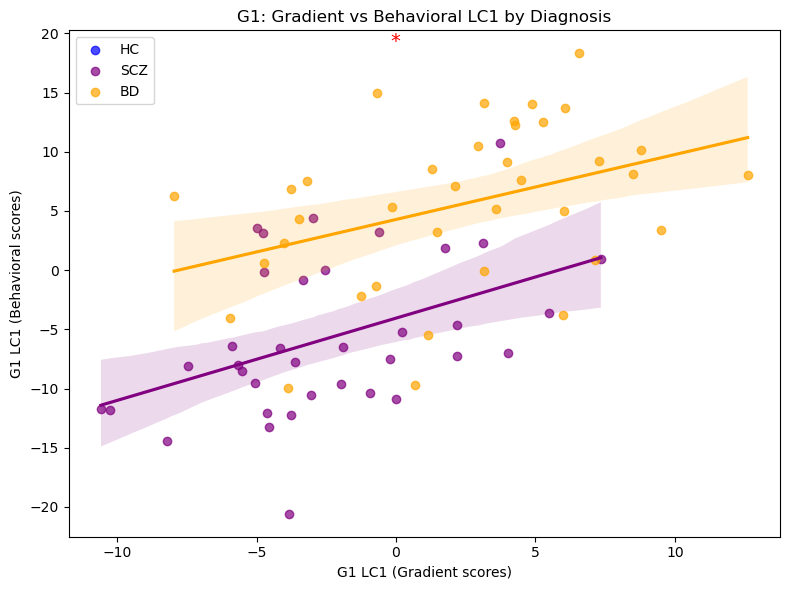


Processing G2 scatter + permutation test...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


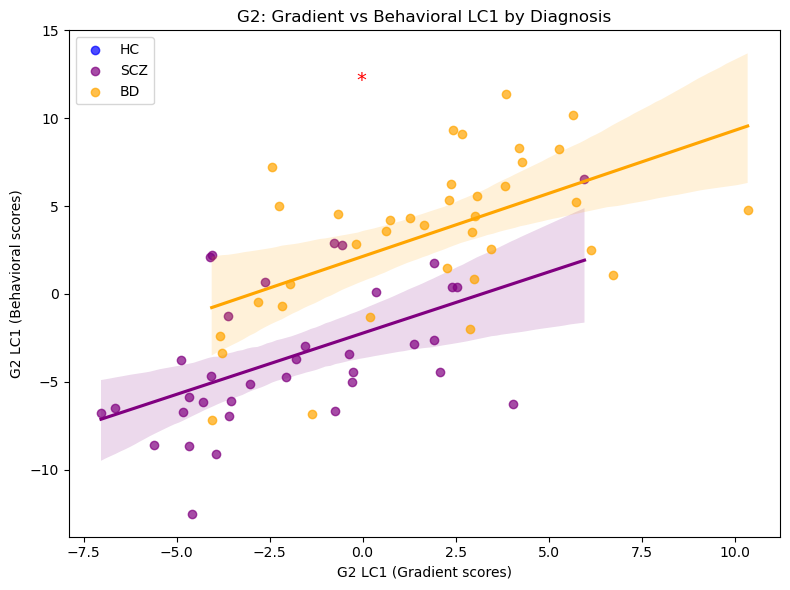


Processing G3 scatter + permutation test...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


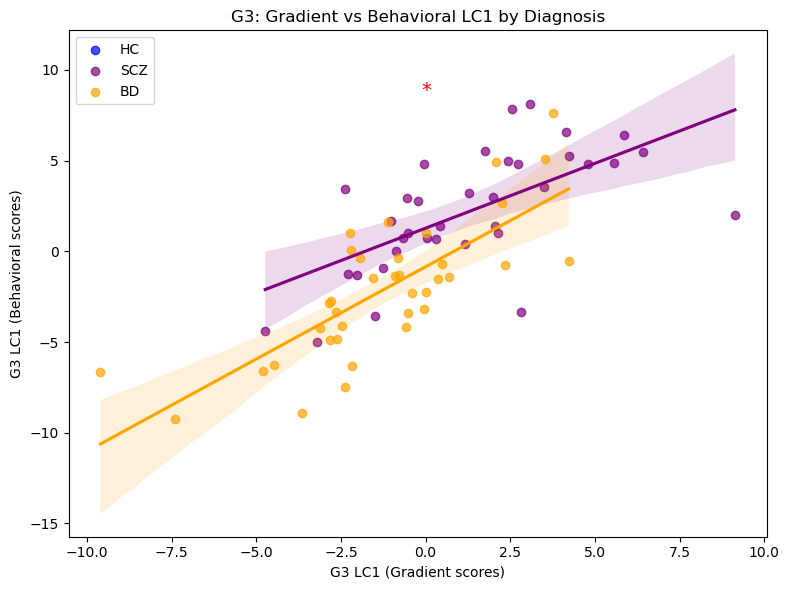


Processing SubG1 scatter + permutation test...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


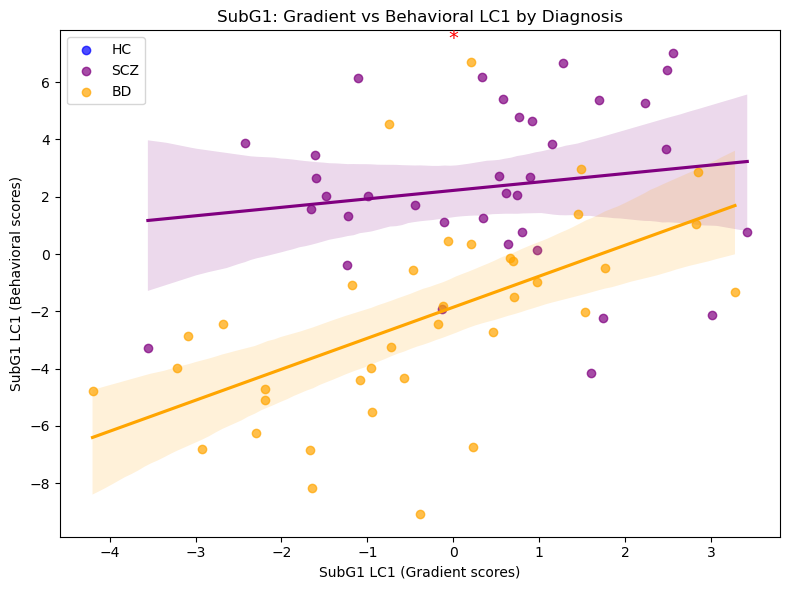


Processing SubG2 scatter + permutation test...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


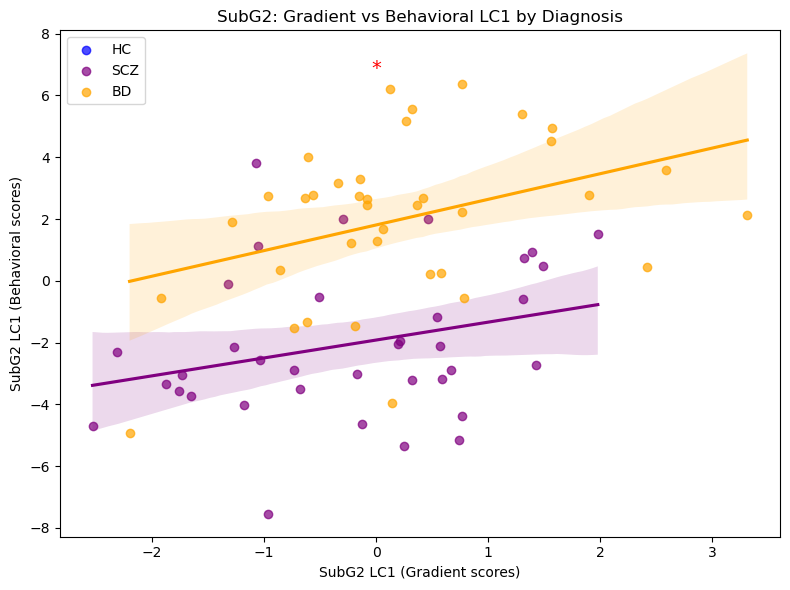


Processing SubG3 scatter + permutation test...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


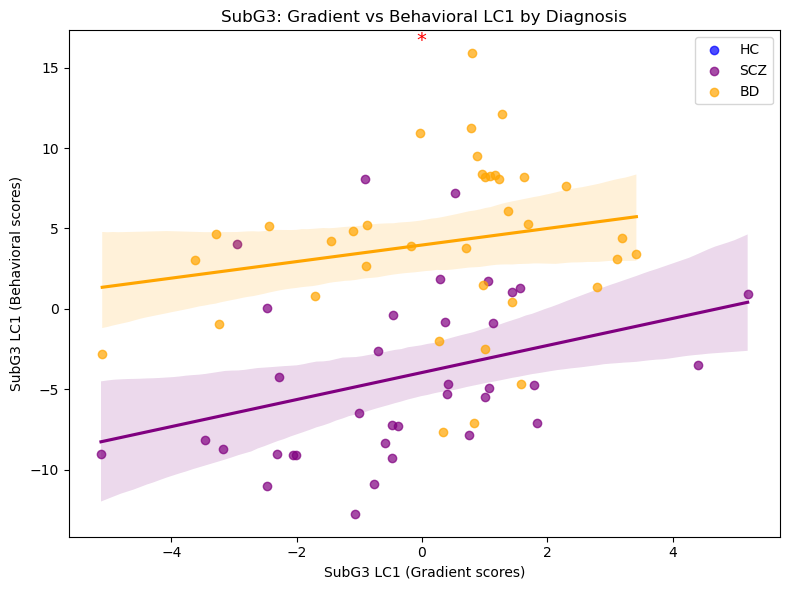

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Diagnosis setup
diagnosis_map = {1:'HC', 2:'SCZ', 3:'BD'}
colors = {'HC':'blue', 'SCZ':'purple', 'BD':'orange'}
pairs = [(1,2),(1,3),(2,3)]

# Merge cortical + subcortical results
all_results = {**results, **results_sub}

for grad_name, res in all_results.items():
    print(f"\nProcessing {grad_name} scatter + permutation test...")

    # Get data
    df_plot = res['patient_df'].copy()
    df_plot['Gradient_LC1'] = res['X_scores']
    df_plot['Behavior_LC1'] = res['Y_scores']

    # --- Pairwise t-tests ---
    pvals_rsfc, pvals_beh = [], []
    for g1, g2 in pairs:
        idx1 = df_plot['diagnosis'] == g1
        idx2 = df_plot['diagnosis'] == g2

        # RSFC
        _, p_val_rsfc = ttest_ind(df_plot.loc[idx1, 'Gradient_LC1'],
                                  df_plot.loc[idx2, 'Gradient_LC1'])
        pvals_rsfc.append(p_val_rsfc)

        # Behavior
        _, p_val_beh = ttest_ind(df_plot.loc[idx1, 'Behavior_LC1'],
                                 df_plot.loc[idx2, 'Behavior_LC1'])
        pvals_beh.append(p_val_beh)

    # FDR correction
    rej_rsfc, pvals_rsfc_fdr, _, _ = multipletests(pvals_rsfc, alpha=0.05, method='fdr_bh')
    rej_beh, pvals_beh_fdr, _, _ = multipletests(pvals_beh, alpha=0.05, method='fdr_bh')

    # --- Plot scatter + regression ---
    plt.figure(figsize=(8,6))
    for diag_code, diag_name in diagnosis_map.items():
        grp = df_plot['diagnosis'] == diag_code
        plt.scatter(df_plot.loc[grp, 'Gradient_LC1'],
                    df_plot.loc[grp, 'Behavior_LC1'],
                    label=diag_name, alpha=0.7, color=colors[diag_name])
        sns.regplot(x=df_plot.loc[grp, 'Gradient_LC1'],
                    y=df_plot.loc[grp, 'Behavior_LC1'],
                    scatter=False, color=colors[diag_name])

    plt.xlabel(f'{grad_name} LC1 (Gradient scores)')
    plt.ylabel(f'{grad_name} LC1 (Behavioral scores)')
    plt.title(f'{grad_name}: Gradient vs Behavioral LC1 by Diagnosis')
    plt.legend()

    # --- Inset: permutation null (if available) ---
    if 'perm_s' in res and 's_obs' in res:
        perm_s = res['perm_s']
        s_obs = res['s_obs']
        axins = inset_axes(plt.gca(), width="40%", height="30%", loc='upper right')
        axins.hist(perm_s[:,0], bins=30, color='gray', alpha=0.7)
        axins.axvline(s_obs[0], color='red', linestyle='--', label='Observed LC1')
        axins.set_title('Permutation null')
        axins.set_xlabel('Singular value')
        axins.set_ylabel('Count')
        axins.legend(fontsize=8)

    # --- Add significance stars for behavior differences ---
    y_max = df_plot['Behavior_LC1'].max()
    star_offsets = [0.1, 0.15, 0.2]
    for i, (g1, g2) in enumerate(pairs):
        if rej_beh[i]:
            x1 = df_plot.loc[df_plot['diagnosis']==g1, 'Gradient_LC1'].mean()
            x2 = df_plot.loc[df_plot['diagnosis']==g2, 'Gradient_LC1'].mean()
            plt.text((x1+x2)/2, y_max + star_offsets[i], '*',
                     ha='center', va='bottom', fontsize=14, color='red')

    plt.tight_layout()
    plt.savefig(f'./new_figures/{grad_name}_scatter.png', dpi=300)
    plt.show()



=== G1 ===
Gradient: SCZ vs BD t=-4.435, p=0.0000
Behavior: SCZ vs BD t=-7.140, p=0.0000


C:\Users\ferraras\AppData\Local\Temp\ipykernel_4172\2598301665.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([


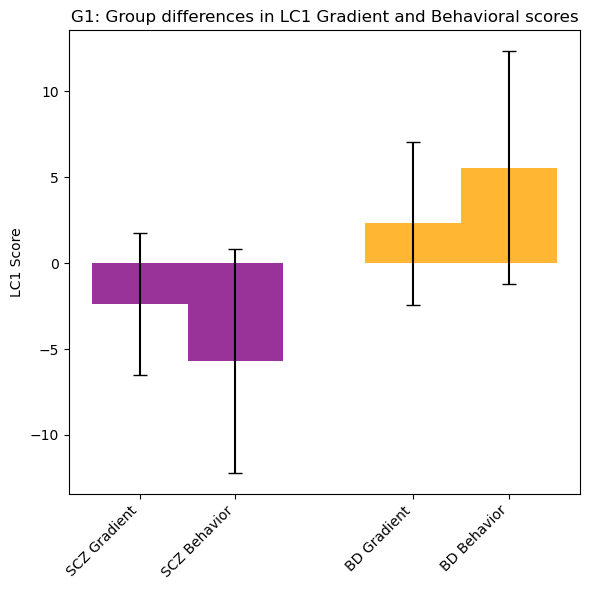


=== G2 ===
Gradient: SCZ vs BD t=-4.737, p=0.0000
Behavior: SCZ vs BD t=-6.920, p=0.0000


C:\Users\ferraras\AppData\Local\Temp\ipykernel_4172\2598301665.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([


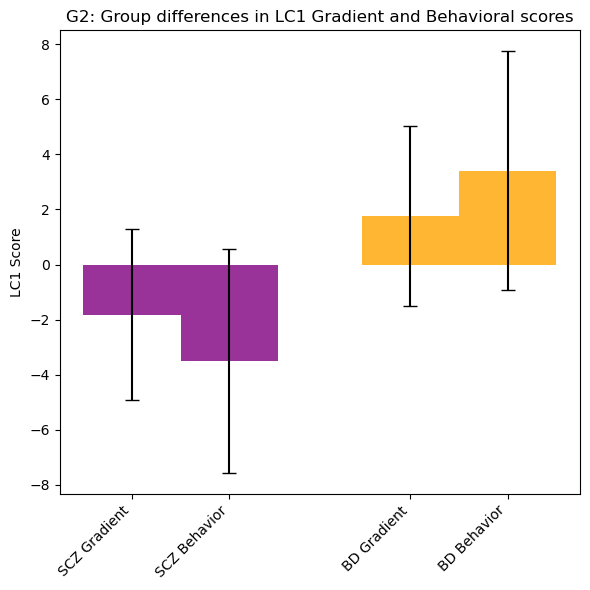


=== G3 ===
Gradient: SCZ vs BD t=3.803, p=0.0003
Behavior: SCZ vs BD t=5.241, p=0.0000


C:\Users\ferraras\AppData\Local\Temp\ipykernel_4172\2598301665.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([


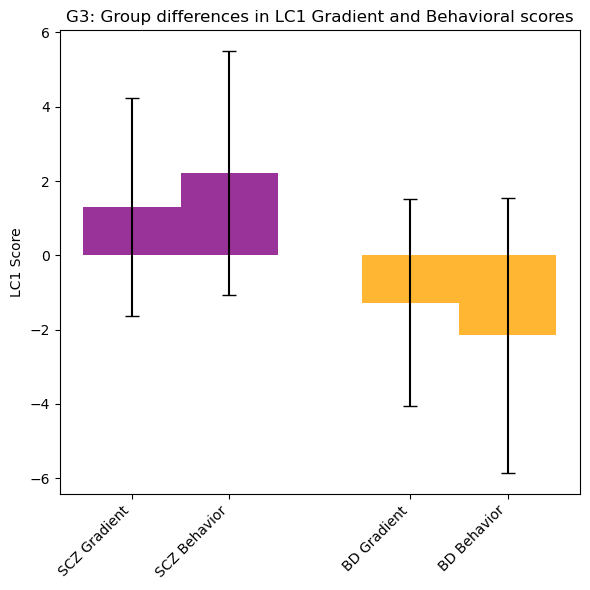


=== SubG1 ===
Gradient: SCZ vs BD t=1.960, p=0.0540
Behavior: SCZ vs BD t=6.114, p=0.0000


C:\Users\ferraras\AppData\Local\Temp\ipykernel_4172\2598301665.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([


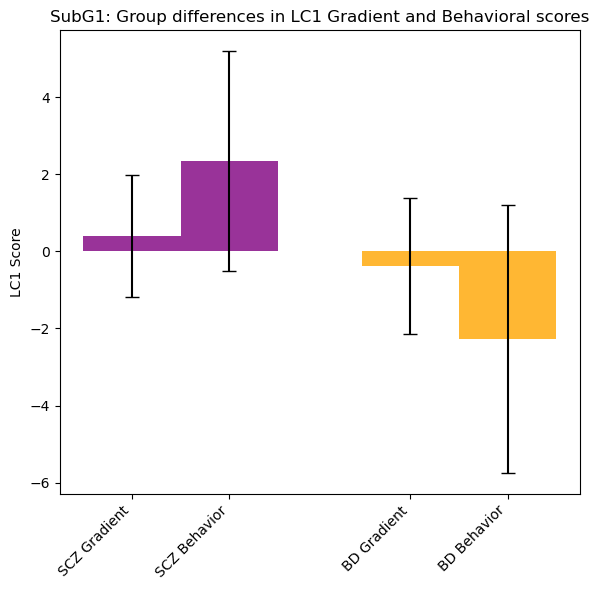


=== SubG2 ===
Gradient: SCZ vs BD t=-1.610, p=0.1118
Behavior: SCZ vs BD t=-6.808, p=0.0000


C:\Users\ferraras\AppData\Local\Temp\ipykernel_4172\2598301665.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([


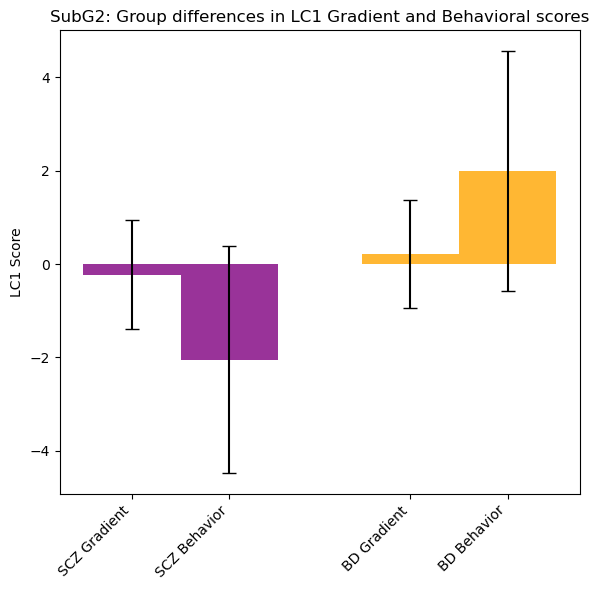


=== SubG3 ===
Gradient: SCZ vs BD t=-1.376, p=0.1732
Behavior: SCZ vs BD t=-6.841, p=0.0000


C:\Users\ferraras\AppData\Local\Temp\ipykernel_4172\2598301665.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([


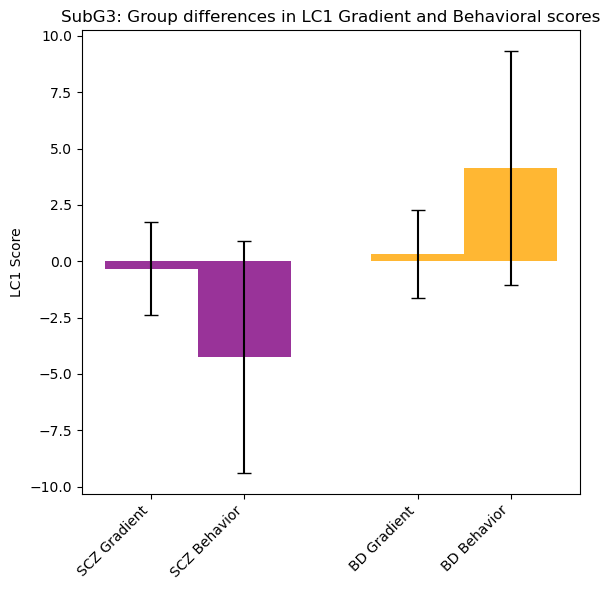

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# ------------------------
# Setup
# ------------------------
diagnosis_map = {2:'SCZ', 3:'BD'}
groups = list(diagnosis_map.values())
colors = {'SCZ':'purple', 'BD':'orange'}
pairs = [('SCZ','BD')]

# Merge cortical and subcortical results
all_results = {**results, **results_sub}

for grad_name, res in all_results.items():
    print(f"\n=== {grad_name} ===")

    # Data
    df_plot = res['patient_df'].copy()
    df_plot['Gradient_LC1'] = res['X_scores']
    df_plot['Behavior_LC1'] = res['Y_scores']

    # ---------- Means & SDs ----------
    scores_dict = {
        'Gradient': df_plot['Gradient_LC1'].values,
        'Behavior': df_plot['Behavior_LC1'].values
    }
    summary_df = pd.DataFrame(columns=['Group','Type','Mean','SD'])

    for typ in ['Gradient','Behavior']:
        for grp_code, grp_name in diagnosis_map.items():
            idx = df_plot['diagnosis'] == grp_code
            summary_df = pd.concat([
                summary_df,
                pd.DataFrame({
                    'Group':[grp_name],
                    'Type':[typ],
                    'Mean':[scores_dict[typ][idx].mean()],
                    'SD':[scores_dict[typ][idx].std()]
                })
            ])

    # ---------- Pairwise t-tests ----------
    pvals = {'Gradient':[], 'Behavior':[]}
    for typ in ['Gradient','Behavior']:
        for g1,g2 in pairs:
            g1_code = [k for k,v in diagnosis_map.items() if v==g1][0]
            g2_code = [k for k,v in diagnosis_map.items() if v==g2][0]
            idx1 = df_plot['diagnosis']==g1_code
            idx2 = df_plot['diagnosis']==g2_code
            if idx1.sum()>1 and idx2.sum()>1:
                t_stat, p_val = ttest_ind(scores_dict[typ][idx1], scores_dict[typ][idx2])
                pvals[typ].append(p_val)
                print(f"{typ}: {g1} vs {g2} t={t_stat:.3f}, p={p_val:.4f}")
            else:
                pvals[typ].append(np.nan)

    # ---------- FDR correction ----------
    rej_grad, pvals_grad_fdr, _, _ = multipletests(pvals['Gradient'], alpha=0.05, method='fdr_bh')
    rej_beh, pvals_beh_fdr, _, _ = multipletests(pvals['Behavior'], alpha=0.05, method='fdr_bh')

    # ---------- Plot grouped bars ----------
    fig, ax = plt.subplots(figsize=(6,6))
    width = 0.35
    x = np.arange(len(groups))  # SCZ, BD

    bar_positions = []
    for i, grp_name in enumerate(groups):
        for j, typ in enumerate(['Gradient','Behavior']):
            pos = x[i] + j*width
            val = summary_df[(summary_df['Group']==grp_name) & (summary_df['Type']==typ)]['Mean'].values[0]
            err = summary_df[(summary_df['Group']==grp_name) & (summary_df['Type']==typ)]['SD'].values[0]
            ax.bar(pos, val, width, yerr=err, capsize=5, alpha=0.8, color=colors[grp_name])
            bar_positions.append(pos)

    # Format x-axis
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f'{g} {t}' for g in groups for t in ['Gradient','Behavior']],
                       rotation=45, ha='right')

    ax.set_ylabel('LC1 Score')
    ax.set_title(f'{grad_name}: Group differences in LC1 Gradient and Behavioral scores')

    plt.tight_layout()
    plt.savefig(f'./new_figures/{grad_name}_barplot.png', dpi=300)
    plt.show()
